In [ ]:
#Para descargar los datos al directorio actual, ejecutar la siguiente linea
!wget https://github.com/exord/UNSAM_IA/raw/master/datasets/train_signs.h5
!wget https://github.com/exord/UNSAM_IA/raw/master/datasets/test_signs.h5

--2020-11-20 03:25:08--  https://github.com/exord/UNSAM_IA/raw/master/datasets/train_signs.h5
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/train_signs.h5 [following]
--2020-11-20 03:25:09--  https://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/train_signs.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13281872 (13M) [application/octet-stream]
Saving to: ‘train_signs.h5’

train_signs.h5      100%[===================>]  12.67M  53.2MB/s    in 0.2s    

2020-11-20 03:25:10 (53.2 MB/s) - ‘train_signs.h5’ saved [13281872/13281872]

--2020-11-20 03:25:10-- 

In [ ]:
import h5py
import numpy as np
def load_dataset(path=''):
    train_dataset = h5py.File(path+'train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_full, y_train_full, X_test, y_test, classes = load_dataset()
y_train_full = y_train_full.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("Lectura completa")

Lectura completa


Para mostrar los datos, los grafico usando la librería mathplotlib de python

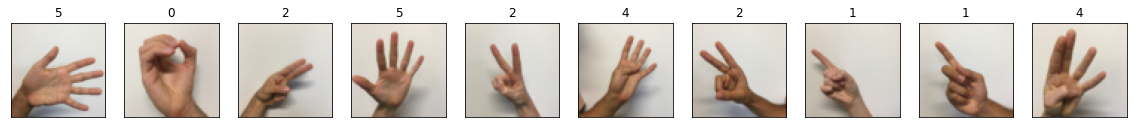

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title(str(y_train_full[i,0]))
    plt.imshow(X_train_full[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Se necesita normalizar los datos, por lo que vemos la forma en la que están construidas las imagenes

In [ ]:
#shape de los datos
X_train_full.shape

(1080, 64, 64, 3)

Veo que tengo 1080 imagenes de 64 * 64 pixeles. Cada pixel está codificado en el sistema RGB de colores (por eso la última dimensión de 3)

In [ ]:
#Como está en el sistema de colores RGB imagino que el minimo es 0 y el maximo es 255, pero por las dudas vamos a verificarlo
print(np.max(X_train_full[:,:,:,:]))
print(np.min(X_train_full[:,:,:,:]))

244
4


Parece que nuestros pixeles estan entre un rango de 4 al 244. No debe haber ningun píxel que sea negro absoluto ni rojo, azul o verde absoluto por lo que ninguno es 0 ni 255 respectivamente. Sin embargo, utilizaré 255 para normalizar mis datos ya que, en un futuro, si tuviese alguna foto que supere el 244 de rgb no estaría bien normalizada

In [ ]:
#Separo en entrenamiento y validacion, y normalizo los pixeles (20% de 1080 es 216)
X_valid, X_train = X_train_full[:216] / 255., X_train_full[216:] / 255.
y_valid, y_train = y_train_full[:216], y_train_full[216:]
X_test = X_test/255.

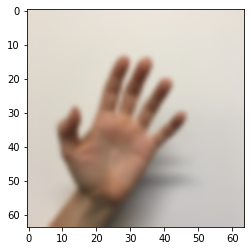

In [ ]:
#Ploteo mi imagen para ver
plt.imshow(X_train[0], cmap='binary', interpolation='bicubic')

Para analizarlo, vamos a construir un modelo en Keras con una estructura inspirada en AlexNet (2012). Esta consistirá en tres bloques convolucionales, seguida de dos layers densos para hacer la clasificación.

Cada bloque convolucional estará constituído por:

    Capa convolucional 2D con activación ReLu, tamaño de ventana (3,3), stride de (1,1) y con un padding SAME para mantener las dimensiones del output iguales a las del input.
    Capa de MaxPooling2D con un tamaño de ventana de (2,2), stride de (2,2) y con padding VALID, para reducir las dimensiones del output a la mitad.

Mi red consistirá de tres bloques convolucionales (cada uno conformado por dos capas, como se describió más arriba) seguidos de capas densas y capas de regularización Dropout. El esquema es el siguiente:

    Bloque Convolucional de 16 filtros
    Bloque Convolucional de 32 filtros
    Bloque Convolucional de 64 filtros
    Dropout del 40%
    Una capa de 524 neuronas, con activación ReLu
    Dropout del 40%
    Una capa de 6 neuronas con activación Softmax, para hacer la clasificación.


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Primero creo mi modelo vacío
modelo_ = Sequential()

#1 CONV / MAX POOLING 16
modelo_.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(64,64,3), strides=(1,1), padding='same'))
modelo_.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))

#2 CONV / MAX POOLING 32
modelo_.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
modelo_.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#3 CONV / MAX POOLING 64
modelo_.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
modelo_.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#Red neuronal convencional
modelo_.add(Dropout(0.4))
modelo_.add(Flatten())
modelo_.add(Dense(524,activation='relu'))
modelo_.add(Dropout(0.4))
modelo_.add(Dense(6,activation='softmax'))

Vamos a ver mi modelo, en este caso vemos el diseño de capas, la cantidad de neuronas activas y cómo están distribuidas

In [ ]:
modelo_.summary()

#La función de loss será sparse_categorical_crossentropy, ya que se trata de un
#clasificador de múltiples clases
modelo_.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

Voy a entrenar mi modelo usando 50 epocas, pero se puede aumentar.
El modelo se detendrá al ver que no hay cambios significativos luego de las 5 epocas de entrenamiento

In [ ]:
n_epochs = 50
batch_size = 32
history = modelo_.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/50
27/27 [==============================] - 4s 135ms/step - loss: 1.7930 - accuracy: 0.2037 - val_loss: 1.7331 - val_accuracy: 0.4120
Epoch 2/50
27/27 [==============================] - 3s 129ms/step - loss: 1.5514 - accuracy: 0.3785 - val_loss: 1.2343 - val_accuracy: 0.6111
Epoch 3/50
27/27 [==============================] - 3s 128ms/step - loss: 1.1515 - accuracy: 0.5648 - val_loss: 0.9815 - val_accuracy: 0.6296
Epoch 4/50
27/27 [==============================] - 3s 124ms/step - loss: 0.9188 - accuracy: 0.6725 - val_loss: 0.7772 - val_accuracy: 0.7546
Epoch 5/50
27/27 [==============================] - 3s 129ms/step - loss: 0.6548 - accuracy: 0.7674 - val_loss: 0.6078 - val_accuracy: 0.8194
Epoch 6/50
27/27 [==============================] - 4s 130ms/step - loss: 0.5107 - accuracy: 0.8380 - val_loss: 0.5124 - val_accuracy: 0.8426
Epoch 7/50
27/27 [==============================] - 6s 213ms/step - loss: 0.3874 - accuracy: 0.8785 - val_loss: 0.4602 - val_accuracy: 0.8426
Epoch 

Text(0.5, 1.0, 'Evolucion del modelo vs epocas')

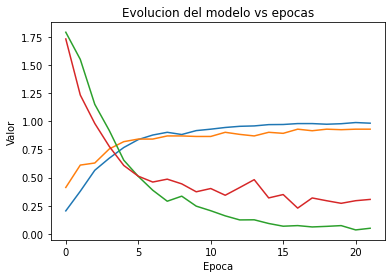

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Valor')
plt.title('Evolucion del modelo vs epocas')

En la figura anterior vimos cómo evoluciona el modelo a medida que avanzan las épocas de entrenamiento.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


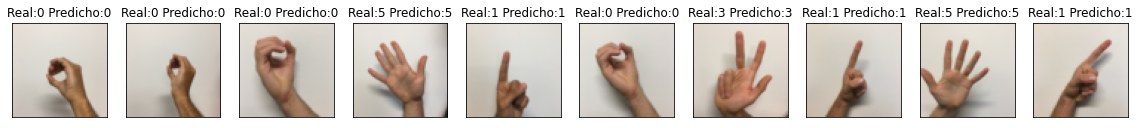

In [ ]:
#Predigo mi modelo
y_predicho = modelo_.predict_classes(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("Real:{} Predicho:{}".format(str(y_test[i,0]), str(y_predicho[i])))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Veo que con los primeros 5 datos de testing, el modelo ha hecho una predicción acertada. Ahora vemos la matriz de confusión, para ver gráficamente la performance de mi modelo

In [ ]:
from sklearn.metrics import confusion_matrix
etiquetas = ['0','1','2','3','4','5']

matriz = confusion_matrix(y_test, y_predicho)

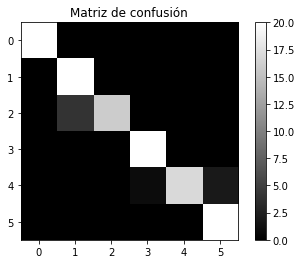

In [ ]:
plt.imshow(matriz)
plt.colorbar()
plt.title("Matriz de confusión")
plt.show()

Veo que hay una gran precisión en las predicciones de mi modelo, aún cuando el modelo predice erróneamente las imagenes de dos dedos con las de un dedo. Veamos las métricas

In [ ]:
import numpy as np
true_pos = np.diag(matriz)
false_pos = np.sum(matriz, axis=0) - true_pos
false_neg = np.sum(matriz, axis=1) - true_pos

precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
accuracy = np.sum(true_pos)/np.sum(matriz)

print("Accuracy = {}\nPrecision = {}\nMean Precision = {}".format(accuracy, precision, precision.mean()))

Accuracy = 0.9416666666666667
Precision = [1.         0.83333333 1.         0.95238095 1.         0.90909091]
Mean Precision = 0.9491341991341992


Veo que mi modelo es bastante bueno, alcanza una precisión del 0,9587. Además no hay una gran cantidad de falsos positivos como se ve en la matriz de confusión